## KNN Assignment

### Import Module

In [46]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib
import missingno as msno

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### Read Data

In [2]:
import pandas as pd
data = pd.read_csv("blackfriday.csv", index_col = 0)
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [3]:
del data['User_ID']
y = data['Gender']
data = data.drop(['Gender'], axis = 1)

#### < Target = Gender >
#### - User ID : 고객 ID
#### - Age : 고객 연령대
#### - Occupation : 고객 직업
#### - City_Category : 고객 거주 도시
#### - Stay_In_Current_City_Years : 현재 도시 거주 년수
#### - Marital_Status : 결혼 여부
#### - Product_Category_1 : 구매 제품 분류 (대)
#### - Product_Category_2 : 구매 제품 분류 (중)
#### - Product_Category_3 : 구매 제품 분류 (소)
#### - Purchase : 구매 가격

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product_ID                  4998 non-null   object 
 1   Age                         4998 non-null   object 
 2   Occupation                  4998 non-null   int64  
 3   City_Category               4998 non-null   object 
 4   Stay_In_Current_City_Years  4998 non-null   object 
 5   Marital_Status              4998 non-null   int64  
 6   Product_Category_1          4998 non-null   int64  
 7   Product_Category_2          3465 non-null   float64
 8   Product_Category_3          1544 non-null   float64
 9   Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 429.5+ KB


##### int - 4개, float - 2개, object - 5개

#### Missing Values

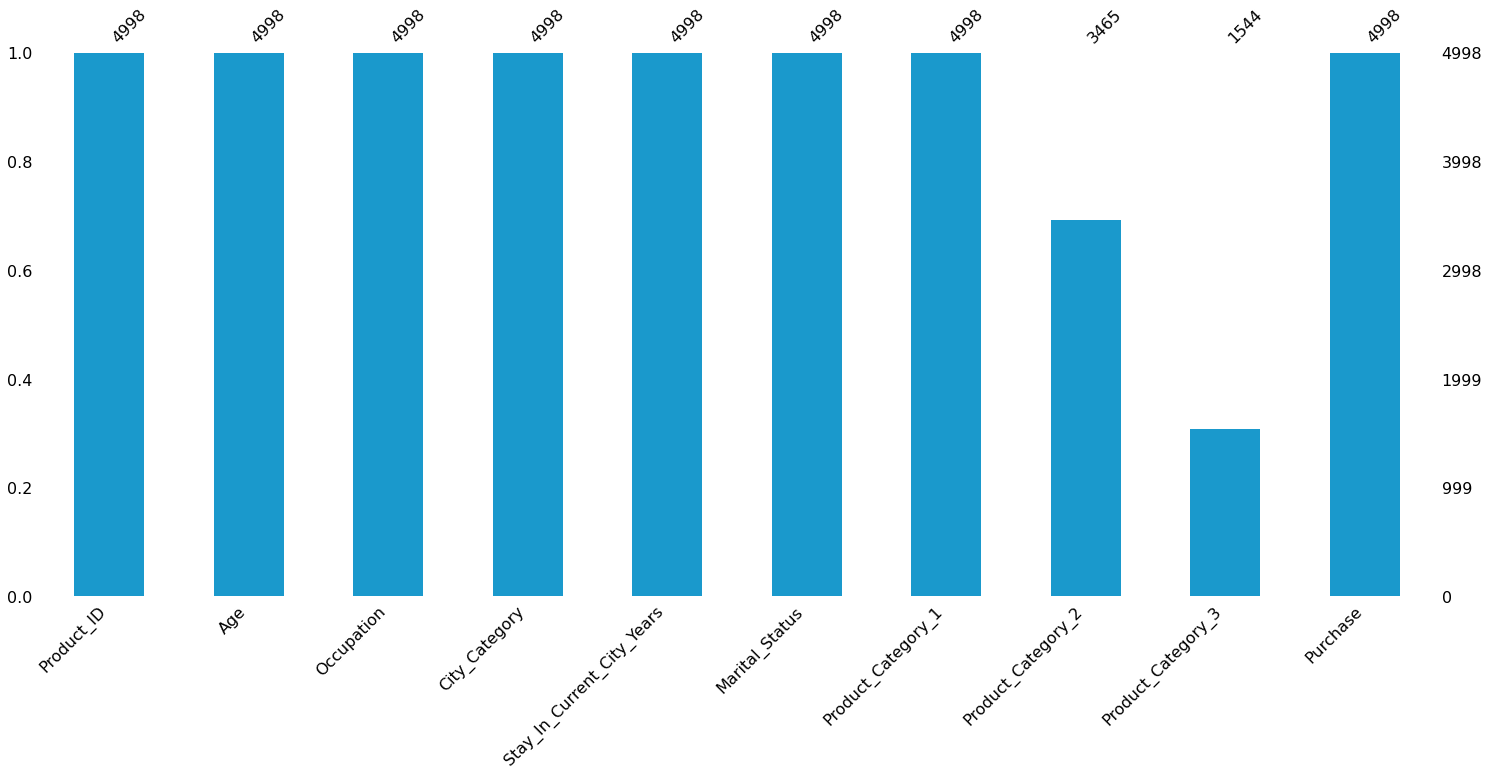

In [5]:
import missingno as msno
msno.bar(df=data, color = (0.1, 0.6, 0.8))
plt.show()

##### 'Product_Category_3의 결측치 비율이 약 70%라 삭제

In [6]:
del data['Product_Category_3']

##### 'Product_Category_2'의 결측치는 중앙값으로 대체

In [7]:
data['Product_Category_2'].median()

9.0

In [8]:
data['Product_Category_2'] = data['Product_Category_2'].fillna(9.0)

In [9]:
data['Product_Category_2']

0       17.0
1        9.0
2        4.0
3        4.0
4        5.0
        ... 
4993    16.0
4994     9.0
4995     6.0
4996     9.0
4997    14.0
Name: Product_Category_2, Length: 4998, dtype: float64

#### 'Purchase' 변수 말고는 전부 categorical variable로 변환

In [10]:
cat_columns = ['Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2']

for col in cat_columns:
    data[col] = data[col].astype(str)

### EDA

In [11]:
data.head()

,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00046042,0-17,10,A,3,0,5,17.0,2010
1,P00347742,0-17,10,A,1,0,7,9.0,4483
2,P00048942,0-17,10,A,1,0,1,4.0,7696
3,P00145242,0-17,10,A,3,0,2,4.0,16429
4,P00106742,0-17,10,A,3,0,3,5.0,5780


In [12]:
def count_plot(feature):
    plt.figure(figsize=(6,4))
    s = sns.countplot(data = data, x = feature, palette='viridis')
    s.set_title(f"{feature} Distribution")
    plt.show()

### Categorical Variable

#### Product_ID

In [13]:
data['Product_ID'].unique()

array(['P00046042', 'P00347742', 'P00048942', ..., 'P00267142',
       'P00085842', 'P00358242'], dtype=object)

##### Product_ID의 값이 너무 많아서 10만단위 나누어줌.

In [14]:
data['Product_ID'] = data['Product_ID'].map(lambda x : x[:4])
data['Product_ID']

0       P000
1       P003
2       P000
3       P001
4       P001
        ... 
4993    P001
4994    P003
4995    P001
4996    P003
4997    P001
Name: Product_ID, Length: 4998, dtype: object

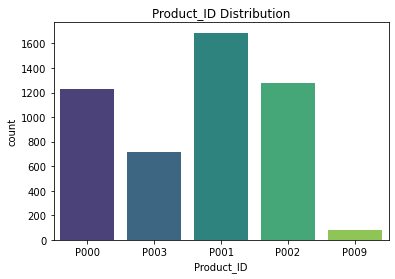

In [15]:
count_plot('Product_ID')

#### Age

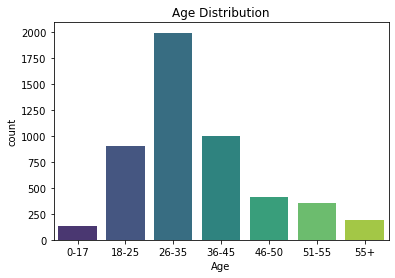

In [16]:
count_plot('Age')

##### 20대 중반부터 30대 중반까지 제일 많이 분포.

#### City_Category

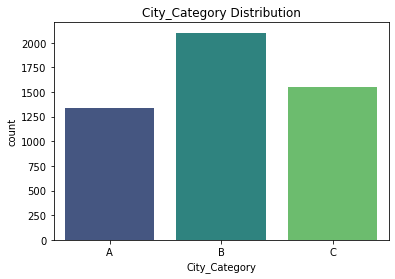

In [17]:
count_plot('City_Category')

#### Stay_In_Current_City_Years

In [18]:
data['Stay_In_Current_City_Years'].value_counts()

1     1758
2      915
3      908
4+     742
0      675
Name: Stay_In_Current_City_Years, dtype: int64

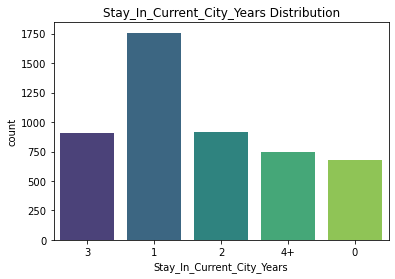

In [19]:
count_plot('Stay_In_Current_City_Years')

##### 1년 거주한 사람이 제일 많았음.

#### Product_Category_1

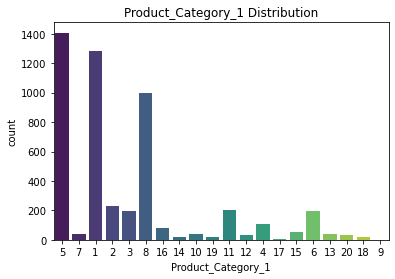

In [20]:
count_plot('Product_Category_1')

##### 1, 5, 8이 눈에 띄게 많음.

#### Product_Category_2

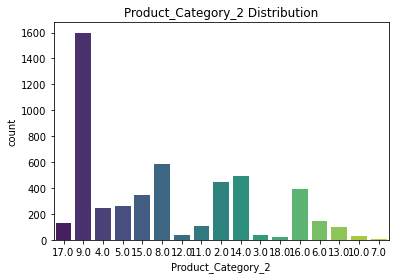

In [21]:
count_plot('Product_Category_2')

##### 상품의 종류는 이름이 숫자로 되어있어 의미를 파악하기 힘듬.

### Numerical Variable

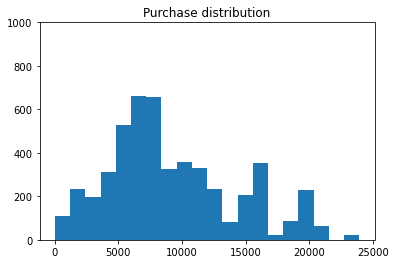

In [22]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.hist(data['Purchase'], bins = 20)
ax.set_ylim(0, 1000)
ax.set_title('Purchase distribution')
plt.show()

##### 최댓값은 이상치로 보여지지 않고 적절하게 분포되어 있음.

### Data Preprocessing

In [23]:
cat_features = data.select_dtypes(include = ['object']).columns.to_list()

num_features = data.select_dtypes(exclude = ['object']).columns.to_list()

#### Scaling

In [24]:
scaler = StandardScaler()

data[num_features] = scaler.fit_transform(data[num_features])
data

,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P000,0-17,10,A,3,0,5,17.0,-1.445300
1,P003,0-17,10,A,1,0,7,9.0,-0.950574
2,P000,0-17,10,A,1,0,1,4.0,-0.307810
3,P001,0-17,10,A,3,0,2,4.0,1.439236
4,P001,0-17,10,A,3,0,3,5.0,-0.691107
...,...,...,...,...,...,...,...,...,...
4993,P001,55+,7,C,1,1,1,16.0,0.493395
4994,P003,55+,1,C,1,1,8,9.0,-1.438298
4995,P001,55+,13,C,3,1,1,6.0,-0.946172
4996,P003,55+,0,C,2,1,12,9.0,-1.564730


#### Encode Categorical Variables

In [25]:
if len(cat_features) > 0:
    data = pd.concat([data[num_features], pd.get_dummies(data[cat_features])], axis = 1)
else:
    data = data[num_features]
data

,Purchase,Product_ID_P000,Product_ID_P001,Product_ID_P002,Product_ID_P003,Product_ID_P009,Age_0-17,Age_18-25,Age_26-35,Age_36-45,...,Product_Category_2_17.0,Product_Category_2_18.0,Product_Category_2_2.0,Product_Category_2_3.0,Product_Category_2_4.0,Product_Category_2_5.0,Product_Category_2_6.0,Product_Category_2_7.0,Product_Category_2_8.0,Product_Category_2_9.0
0,-1.445300,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.950574,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.307810,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.439236,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-0.691107,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.493395,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4994,-1.438298,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4995,-0.946172,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4996,-1.564730,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Encode Target

In [26]:
le = LabelEncoder()

y = le.fit_transform(y)

### Data Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, stratify = y, shuffle = True, random_state = 1212)

### KNN

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Score : {:.3f}'.format(knn.score(X_test, y_test)))

Score : 0.749


In [30]:
results = knn.predict(X_test)
results

array([1, 0, 1, ..., 1, 1, 1])

In [31]:
pd.crosstab(y_test, results, rownames=['Real'], colnames=['Predicted'], margins = True, margins_name = 'total')

Predicted,0,1,total
Real,,,
0,89,281,370
1,95,1035,1130
total,184,1316,1500


##### 0을 잘 예측하지 못함.

In [32]:
from sklearn import metrics

print(metrics.classification_report(y_test, results, digits=2))

              precision    recall  f1-score   support

           0       0.48      0.24      0.32       370
           1       0.79      0.92      0.85      1130

    accuracy                           0.75      1500
   macro avg       0.64      0.58      0.58      1500
weighted avg       0.71      0.75      0.72      1500



### Optimize K 

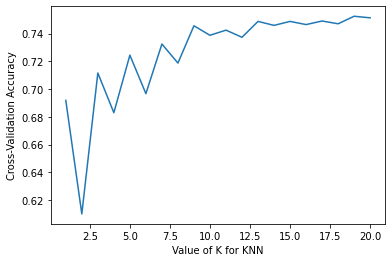

In [34]:
from sklearn.model_selection import cross_val_score
k_range = list(range(1,21))           # k를 1~100까지 고려하여 최적의 k를 찾을 것이다.
k_score = []                        # 각 k들의 성능을 비교하기 위한 리스트생성이다.

for k in k_range :
    knn = KNeighborsClassifier(k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring = "accuracy")    # 10-fold cross-validation
    k_score.append(scores.mean())                    # 10-fold 각각 정확도의 평균으로 성능계산

plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

##### k값이 커지면 성능이 오르지만 0.75 언저리에 계속 머무르는 모습을 보임.

In [38]:
k_list = [i for i in range(1, 100) if i%2 !=0]
cv_scores = []

for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p = 2)
# p=1: manhattan_distance, p=2: euclidean_distance, # p=l_p: minkoski_distance
    
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

100%|███████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


In [39]:
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print('Best K : ', best_k)

Best K :  [51]


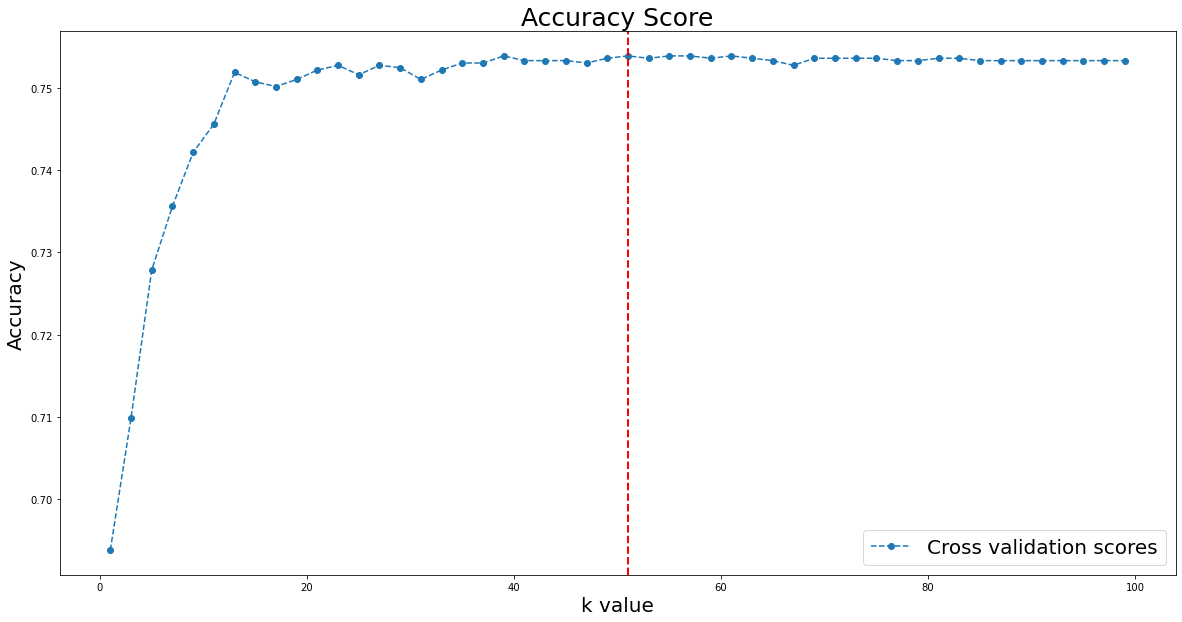

In [40]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker='o', linestyle='dashed')
plt.legend(['Cross validation scores'], fontsize=20)
plt.xlabel('k value', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy Score', fontsize=25)
plt.axvline(best_k[0], color='r', linestyle='--', linewidth=2)
plt.show()

##### k가 51일때 accuracy가 가장 높게 나타남.